In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import urllib.request
from kiwipiepy import Kiwi
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="naver_shopping.txt")

('naver_shopping.txt', <http.client.HTTPMessage at 0x28e85fc70>)

In [4]:
df = pd.read_csv("naver_shopping.txt", sep="\t", header=None, encoding="utf-8-sig")
df.columns = ['score', 'reviews']
print(len(df))
df.head()

200000


score                                            reviews
0      5                                            배공빠르고 굿
1      2                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2      5  아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3      2  선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4      5                  민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ

In [5]:
df['label'] = np.select([df.score > 3], [1], default=0)
df.head()

score                                            reviews  label
0      5                                            배공빠르고 굿      1
1      2                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고      0
2      5  아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...      1
3      2  선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...      0
4      5                  민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ      1

In [6]:
df.drop_duplicates(subset=['reviews'], inplace=True) # Drop duplicate reviews
print(df.isnull().values.any())
print(len(df))

df['reviews'] = df['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")
df['reviews'].replace('', np.nan, inplace=True)
print(df.isnull().sum())

False
199908
score      0
reviews    0
label      0
dtype: int64


Train Reviews :  159926
Test_Reviews :  39982
   label  count
0      0  79926
1      1  80000


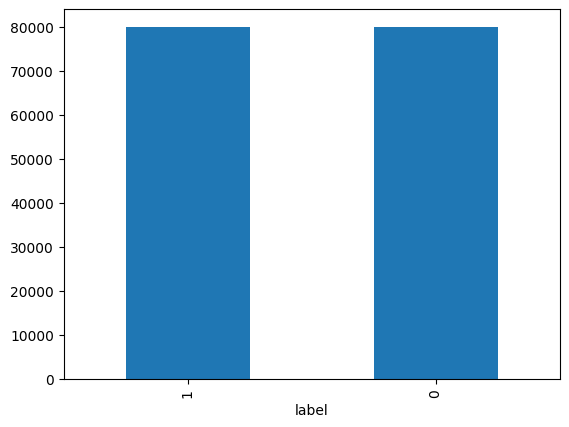

In [7]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=97)
print("Train Reviews : ", len(train_data))
print("Test_Reviews : ", len(test_data))
train_data['label'].value_counts().plot(kind='bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [8]:
# Tokenize

kiwi = Kiwi()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
def tokenizing(sentence):
    try:
        if not sentence:
            raise ValueError
        words = [token[0] for token in kiwi.tokenize(sentence) if token[0] not in stopwords]
    except ValueError as e:
        print(e)
    
    return words

In [10]:
train_data['tokenized']=train_data['reviews'].apply(tokenizing)
print("train finished")
test_data['tokenized']=test_data['reviews'].apply(tokenizing)
print("test finished")

train finished
test finished


In [11]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [12]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('었', 51813), ('어요', 43638), ('ᆫ', 37418), ('어', 37177), ('.', 35651), ('네요', 33312), ('어서', 33160), ('는데', 22668), ('안', 21199), ('거', 17430), ('..', 16150), ('ᆸ니다', 15424), ('ᆯ', 14613), ('너무', 14459), ('되', 14290), ('있', 14164), ('쓰', 12830), ('나', 11792), ('것', 11067), ('...', 10434)]


In [13]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('어요', 60533), ('좋', 40202), ('었', 37750), ('.', 28732), ('어', 27976), ('어서', 23486), ('ᆫ', 22084), ('네요', 21111), ('ᆸ니다', 19892), ('잘', 19637), ('구매', 17084), ('습니다', 14857), ('있', 13263), ('배송', 13042), ('는데', 12974), ('~', 12599), ('쓰', 11964), ('ᆯ', 10830), ('먹', 10254), ('빠르', 10074)]


긍정 리뷰의 평균 길이 : 15.627125
부정 리뷰의 평균 길이 : 20.24949328128519


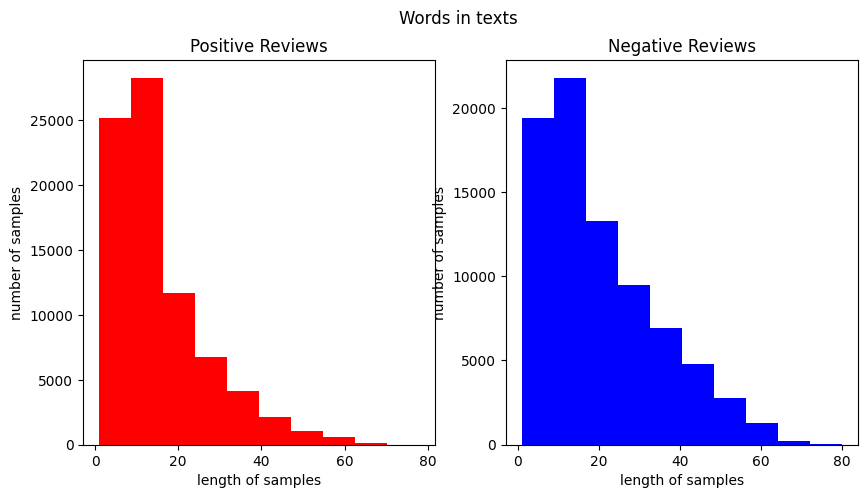

In [14]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [15]:
X_train = train_data['tokenized'].values
Y_train = train_data['label'].values
X_test = test_data['tokenized'].values
Y_test = test_data['label'].values
X_train

array([list(['재', '구매', '너무', '만족', 'ᆸ니다', '감사', 'ᆸ니다']),
       list(['자리', '많이', '안', '차지', '디자인', '깔끔', '어서', '좋', '어요']),
       list(['화장품', '케이스', '로', '쓰', 'ᆯ려고', '주문', '엇', '는데', '깨지', 'ᆷ', '없이', '잘', '다니', 'ᆸ니다', '..', '실용', '성', '좋', '착하', 'ᆫ', '가격', 'ᆸ니다']),
       ...,
       list(['아이보리', '안경', '닦', '안경', '케이스', '구매', '었', '는데', '요', '.', '우선', '안경', '케이스', '예쁘', '어서', '잘', '쓰', '있', '어요', '.', '그리고', '안경', '닦이', '깔끔', '예쁘', '구요', '.', '판매자', '분', '문의', '드리', '엇', '때', '대처', '빨리', '어', '주', '시', '정말', '친절', '시', '었', '어요', '.', '다음', '안경', '닦', '이랑', '케이스', '사', 'ᆯ', '때', '자주', '이용', 'ᆯ', '것', '같', '어', '요', '!', '감사', 'ᆸ니다']),
       list(['커버', '력', '보통', '보다', '조금', '좋', '정도', '.', '팔', '아주', '연하', 'ᆫ', '점', '있', '는데', '희미', 'ᆫ', '그', '점', '가리', 'ᆯ', '정도', 'ᆸ니다', '.']),
       list(['재', '구매', '사장', '님', '전', '말씀', '드리', '었', '는데', '중대', '혼합', '으로', '시키', '면', '중대', '1', '대', '1', '로', '생각', '주문', '거', 'ᆫ데', '소', '중', '90', '프로', '대', '짜리', '10', '프로', '로', '보내', '어', '

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(len(tokenizer.word_index))

42310


In [25]:
threshold=2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq = rare_freq + value

print("Size of Vocabulary :", total_cnt)
print(f'등장빈도가 {threshold-1}번 이하인 희귀 단어의 수 : {rare_cnt}')
print("단어 집합에서 희귀 단어의 비율 : ", (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq/total_freq)*100)

Size of Vocabulary : 42310
등장빈도가 1번 이하인 희귀 단어의 수 : 23940
단어 집합에서 희귀 단어의 비율 :  56.582368234459935
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 0.8345444220605578


In [26]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  18372


In [27]:
# 정수 인코딩 과정에서 vocab_size 보다 큰 숫자가 부여된 단어들은 OOV로 변환
# Out Of Vocabulary
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 80
리뷰의 평균 길이 : 17.93723972337206


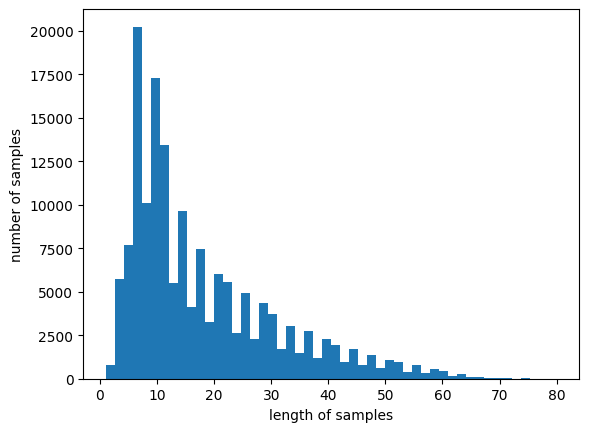

In [28]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if len(sentence) <= max_len:
            count += 1
    print(f'길이가 {max_len}이하인 샘플의 비율 {(count)/len(nested_list)*100}')
    
max_len = 75
below_threshold_len(max_len, X_train)

길이가 75이하인 샘플의 비율 99.99374710803747


In [30]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [21]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='var_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

2023-11-21 19:35:20.712767: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-21 19:35:20.712815: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-21 19:35:20.712824: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-21 19:35:20.713043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-21 19:35:20.713060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2023-11-21 19:35:22.009904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-21 19:35:22.332438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-21 19:35:23.939432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2000/2000 [==============================] - ETA: 0s - loss: 0.2601 - acc: 0.9025

2023-11-21 19:36:16.886456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-21 19:36:16.946153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.92059, saving model to best_model.h5
2000/2000 [==============================] - 59s 28ms/step - loss: 0.2601 - acc: 0.9025 - val_loss: 0.2187 - val_acc: 0.9206
Epoch 2/15
   3/2000 [..............................] - ETA: 1:06 - loss: 0.2188 - acc: 0.9062

/Users/chodaehyeon/miniconda/envs/practice/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - ETA: 0s - loss: 0.2073 - acc: 0.9254WARNING:tensorflow:Early stopping conditioned on metric `var_loss` which is not available. Available metrics are: loss,acc,val_loss,val_acc

Epoch 2: val_acc improved from 0.92059 to 0.92078, saving model to best_model.h5
2000/2000 [==============================] - 53s 27ms/step - loss: 0.2073 - acc: 0.9254 - val_loss: 0.2155 - val_acc: 0.9208
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1945 - acc: 0.9307WARNING:tensorflow:Early stopping conditioned on metric `var_loss` which is not available. Available metrics are: loss,acc,val_loss,val_acc

Epoch 3: val_acc improved from 0.92078 to 0.92866, saving model to best_model.h5
2000/2000 [==============================] - 59s 29ms/step - loss: 0.1945 - acc: 0.9307 - val_loss: 0.1989 - val_acc: 0.9287
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1855 - acc: 0.9340WARNING:tensorflow:Early stopping conditi

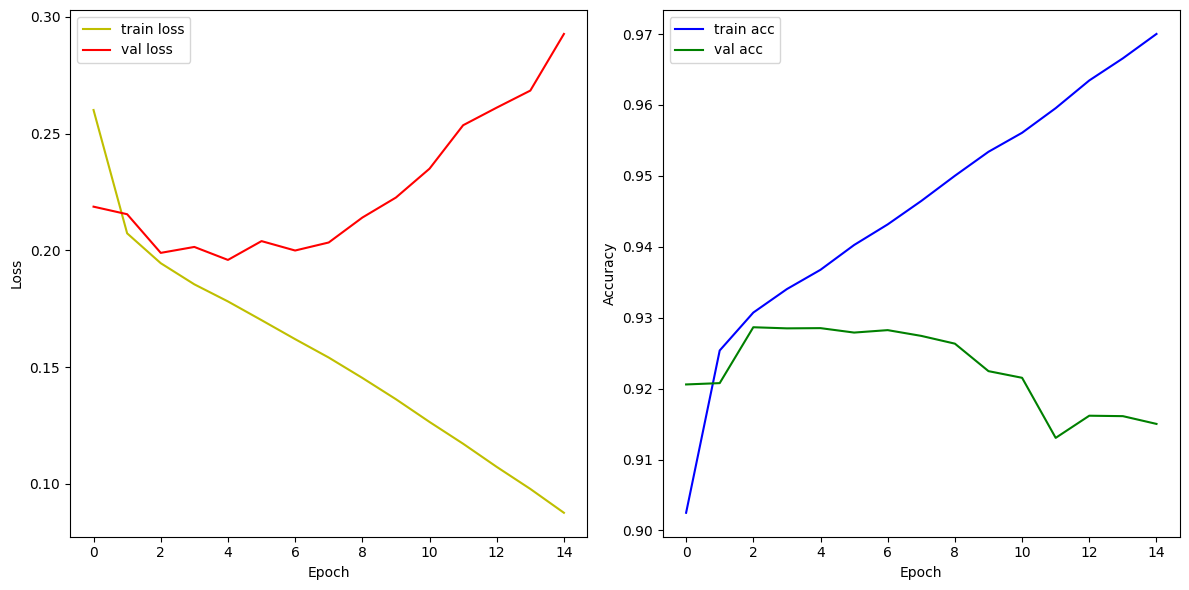

In [25]:
# 학습 과정 표시
import matplotlib.pyplot as plt

# 훈련 손실과 검증 손실을 나눠서 그래프 그리기
plt.figure(figsize=(12, 6))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'y', label='train loss')  # 훈련 손실
plt.plot(history.history['val_loss'], 'r', label='val loss')  # 검증 손실
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], 'b', label='train acc')  # 훈련 정확도
plt.plot(history.history['val_acc'], 'g', label='val acc')  # 검증 정확도
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
loaded_model = load_model('best_model.h5')
print('테스트 정확도 : %.4f' % (loaded_model.evaluate(X_test, Y_test)[1]))

2023-11-21 19:50:00.116989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-21 19:50:00.192922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 11s 8ms/step - loss: 0.2028 - acc: 0.9272
테스트 정확도 : 0.9272


In [24]:
model.save('best_model.h5')

In [31]:
new_model = tf.keras.models.load_model('best_model.h5')

In [38]:
def sentiment_predict(new_sentence:str):
    new_sentence = re.sub('r[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', new_sentence)
    new_sentence = tokenizing(new_sentence)
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)
    score = float(new_model.predict(pad_new))

    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score*100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1-score)*100))

In [39]:
sentiment_predict("뭘봐")

2023-11-24 20:41:49.129800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-24 20:41:49.322027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 905ms/step
92.22% 확률로 부정 리뷰입니다.


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


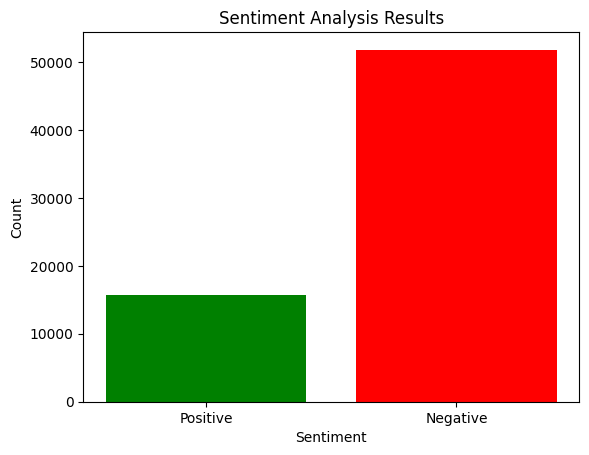

In [42]:
positive_comment = []
negative_comment = []

def sentiment_predict_and_visualize(csv_file_path, model):
    # CSV 파일 읽기
    df = pd.read_csv(csv_file_path)
    
    # 초기화
    positive_count = 0
    negative_count = 0

    # 각 문장에 대한 감성 분석 수행
    for idx, row in df.iterrows():
        new_sentence = row['comment']  # '문장'에 실제 CSV 파일의 열 이름을 사용하세요
        new_sentence = re.sub('r[^ㄱ-ㅎㅏ-ㅣ가-힣]', '', new_sentence)
        new_sentence = tokenizing(new_sentence)
        encoded = tokenizer.texts_to_sequences([new_sentence])
        pad_new = pad_sequences(encoded, maxlen = max_len)
        score = float(new_model.predict(pad_new))

        if score > 0.5:
            positive_comment.append(new_sentence)
            positive_count += 1
        else:
            negative_comment.append(new_sentence)
            negative_count += 1

    # 시각화
    labels = ['Positive', 'Negative']
    counts = [positive_count, negative_count]

    plt.bar(labels, counts, color=['green', 'red'])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Sentiment Analysis Results')
    plt.show()

# 사용 예시
csv_file_path = "merged_result.csv"
sentiment_predict_and_visualize(csv_file_path, new_model)

In [49]:
import math

positive_rate = len(positive_comment) / (len(positive_comment) + len(negative_comment)) * 100
negative_rate = len(negative_comment) / (len(positive_comment) + len(negative_comment)) * 100

print(f'긍정 의견 : {len(positive_comment)}')
print(f'부정 의견 : {len(negative_comment)}')
print(f'긍정 의견 비율 : {round(positive_rate)}%')
print(f'부정 의견 비율 : {round(negative_rate)}%')

긍정 의견 : 15651
부정 의견 : 51808
긍정 의견 비율 : 23%
부정 의견 비율 : 77%
